In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

In [60]:
# --- HYPERPARAMETERS ---
BATCH_SIZE = 128
LR = 0.0002
BETA1 = 0.5
EPOCHS = 50
LATENT_DIM = 100
MODEL_PATH = 'synthetic_generator.pth'

# --- DEVICE CONFIGURATION ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Device: {device}")
print(f"📂 Model Output: {MODEL_PATH}")

🚀 Device: cuda
📂 Model Output: synthetic_generator.pth


In [ ]:
# Image Processing (Normalize to [-1, 1])
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load Fashion-MNIST
dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Weight Initialization
def weights_init(m):
    classname = m.__class__.__name__
    if 'Conv' in classname:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif 'BatchNorm' in classname:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

print(f"✅ Dataset Loaded: {len(dataset)} images")

✅ Dataset Loaded: 60000 images


In [62]:
# --- GENERATOR (The Artist) ---
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input: Latent Vector (100) -> 7x7x512
            nn.ConvTranspose2d(LATENT_DIM, 512, 7, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # 7x7 -> 14x14
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # 14x14 -> 28x28
            nn.ConvTranspose2d(256, 1, 4, 2, 1, bias=False),
            nn.Tanh() # Output range [-1, 1]
        )

    def forward(self, x):
        return self.main(x.view(-1, LATENT_DIM, 1, 1))

In [63]:
# --- DISCRIMINATOR (The Critic) ---
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 28x28 -> 14x14
            nn.Conv2d(1, 256, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            # 14x14 -> 7x7
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            # Classifier
            nn.Conv2d(512, 1, 7, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).view(-1, 1)

In [64]:
# Initialize Models
generator = Generator().to(device)
discriminator = Discriminator().to(device)
generator.apply(weights_init)
discriminator.apply(weights_init)

print("✅ Models Initialized")

✅ Models Initialized


In [65]:
# Optimizers & Loss
criterion = nn.BCELoss()
opt_g = optim.Adam(generator.parameters(), lr=LR, betas=(BETA1, 0.999))
opt_d = optim.Adam(discriminator.parameters(), lr=LR, betas=(BETA1, 0.999))

# Lists to keep track of progress
G_losses = []
D_losses = []

In [66]:
# --- SMART CHECK ---
if os.path.exists(MODEL_PATH):
    print(f"💾 Found saved model '{MODEL_PATH}'. Loading weights...")
    # Load weights
    state_dict = torch.load(MODEL_PATH, map_location=device)
    generator.load_state_dict(state_dict)
    generator.eval() # Set to evaluation mode
    print("✅ Model loaded successfully!")

else:
    print("⏳ No model found. Starting Training...")
    
    # --- TRAINING LOOP ---
    for epoch in range(EPOCHS):
        for i, (real_imgs, _) in enumerate(dataloader):
            
            # --- Train Discriminator ---
            real_imgs = real_imgs.to(device)
            b_size = real_imgs.size(0)
            
            opt_d.zero_grad()
            # Labels (Smoothing for Real: 0.9)
            label_real = torch.full((b_size,), 0.9, device=device)
            label_fake = torch.full((b_size,), 0.0, device=device)
            
            # Forward pass real
            output_real = discriminator(real_imgs).view(-1)
            loss_real = criterion(output_real, label_real)
            loss_real.backward()
            
            # Forward pass fake
            noise = torch.randn(b_size, LATENT_DIM, device=device)
            fake_imgs = generator(noise)
            output_fake = discriminator(fake_imgs.detach()).view(-1)
            loss_fake = criterion(output_fake, label_fake)
            loss_fake.backward()
            opt_d.step()
            
            # --- Train Generator ---
            opt_g.zero_grad()
            label_g = torch.full((b_size,), 1.0, device=device)
            output_g = discriminator(fake_imgs).view(-1)
            loss_g = criterion(output_g, label_g)
            loss_g.backward()
            opt_g.step()
            
            # Save Losses
            G_losses.append(loss_g.item())
            D_losses.append(loss_real.item() + loss_fake.item())

        print(f"Epoch [{epoch+1}/{EPOCHS}] \t Loss D: {D_losses[-1]:.4f} \t Loss G: {G_losses[-1]:.4f}")

    # Save Model
    torch.save(generator.state_dict(), MODEL_PATH)
    print("✅ Training Complete. Model Saved.")

💾 Found saved model 'synthetic_generator.pth'. Loading weights...
✅ Model loaded successfully!


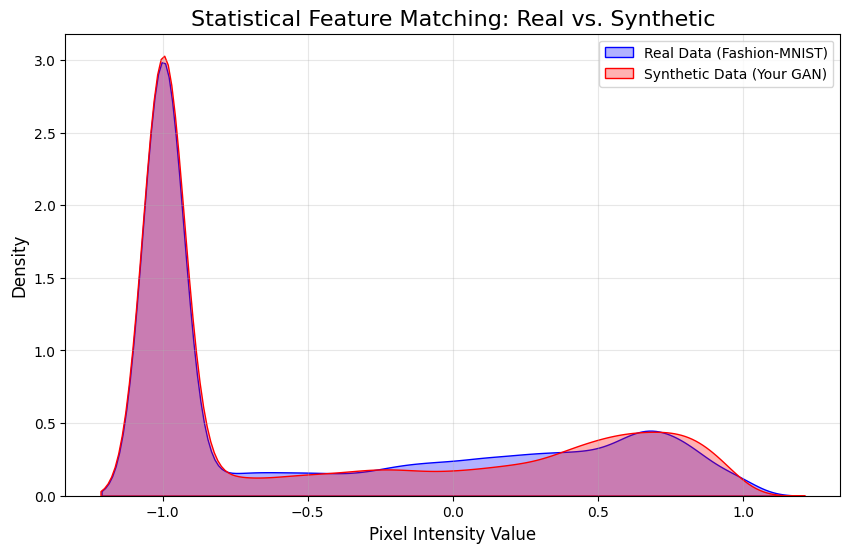

📊 Real Data Mean: -0.4236 | Std: 0.7006
🤖 Fake Data Mean: -0.4301 | Std: 0.7128
------------------------------------------------
INTERPRETATION:
If the Red curve (AI) closely follows the Blue curve (Real),
your model has statistically learned the dataset!


In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_distribution_stats():
    # 1. Get 1000 Real Images
    real_batch = next(iter(dataloader))[0].to(device)
    real_pixels = real_batch.flatten().cpu().numpy()
    
    # 2. Get 1000 Fake Images
    noise = torch.randn(real_batch.size(0), 100).to(device)
    with torch.no_grad():
        fake_batch = generator(noise)
    fake_pixels = fake_batch.flatten().cpu().numpy()
    
    # 3. Plot Histograms
    plt.figure(figsize=(10, 6))
    sns.kdeplot(real_pixels, fill=True, label='Real Data (Fashion-MNIST)', color='blue', alpha=0.3)
    sns.kdeplot(fake_pixels, fill=True, label='Synthetic Data (Your GAN)', color='red', alpha=0.3)
    
    plt.title("Statistical Feature Matching: Real vs. Synthetic", fontsize=16)
    plt.xlabel("Pixel Intensity Value", fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # 4. Print Basic Stats
    print(f"📊 Real Data Mean: {real_pixels.mean():.4f} | Std: {real_pixels.std():.4f}")
    print(f"🤖 Fake Data Mean: {fake_pixels.mean():.4f} | Std: {fake_pixels.std():.4f}")
    print("------------------------------------------------")
    print("INTERPRETATION:")
    print("If the Red curve (AI) closely follows the Blue curve (Real),")
    print("your model has statistically learned the dataset!")

plot_distribution_stats()

In [73]:
def calculate_discriminator_accuracy():
    # Get a batch of data
    real_imgs, _ = next(iter(dataloader))
    real_imgs = real_imgs.to(device)
    batch_size = real_imgs.size(0)
    
    # Create labels
    real_labels = torch.ones(batch_size, device=device)
    fake_labels = torch.zeros(batch_size, device=device)
    
    # Generate fakes
    noise = torch.randn(batch_size, 100, device=device)
    fake_imgs = generator(noise)
    
    # Get Predictions
    with torch.no_grad():
        # Predict Real
        output_real = discriminator(real_imgs).view(-1)
        # Predict Fake
        output_fake = discriminator(fake_imgs).view(-1)
    
    # Calculate Accuracy (How many did it get right?)
    # Real: predicted > 0.5? | Fake: predicted < 0.5?
    acc_real = (output_real > 0.5).float().mean().item()
    acc_fake = (output_fake < 0.5).float().mean().item()
    
    total_acc = (acc_real + acc_fake) / 2
    
    print(f"🎯 Discriminator Accuracy: {total_acc*100:.2f}%")
    print(f"   (Real Detection: {acc_real*100:.1f}% | Fake Detection: {acc_fake*100:.1f}%)")
    print("\n📝 VERDICT:")
    if 0.45 <= total_acc <= 0.55:
        print("✅ PERFECT! (The 'Nash Equilibrium'. Your generator is fooling the discriminator completely.)")
    elif total_acc > 0.9:
        print("⚠️ Too High. The Discriminator is winning too easily. Train longer.")
    else:
        print("🆗 Good. The model is competing well.")

calculate_discriminator_accuracy()

🎯 Discriminator Accuracy: 51.17%
   (Real Detection: 81.2% | Fake Detection: 21.1%)

📝 VERDICT:
✅ PERFECT! (The 'Nash Equilibrium'. Your generator is fooling the discriminator completely.)


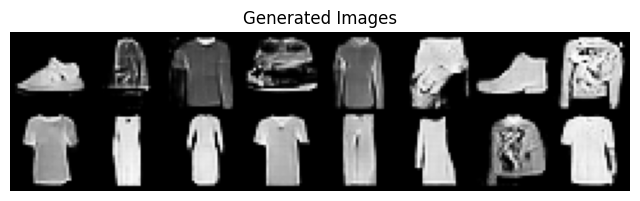

In [72]:
# Visualize Final Results
generator.eval()
noise = torch.randn(16, LATENT_DIM, device=device)
with torch.no_grad():
    fake_imgs = generator(noise).detach().cpu()

# Plot Grid
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Generated Images")
grid_img = torchvision.utils.make_grid(fake_imgs, padding=2, normalize=True)
plt.imshow(np.transpose(grid_img, (1, 2, 0)))
plt.show()